# **Modeling DietCare for Recommendation Recipe**

## **Download Dataset**

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d irkaal/foodcom-recipes-and-reviews

In [ ]:
!unzip /content/foodcom-recipes-and-reviews.zip

## **Import Library**

In [ ]:
import pandas as pd
import numpy as  np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

: 

## **Import Dataset**

In [ ]:
data = pd.read_csv('/content/recipes.csv')

In [ ]:
data.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [ ]:
data.shape

(522517, 28)

## **Data Preprocessing**

In [ ]:
data.describe()

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
count,522517.000000,5.225170e+05,269294.000000,275028.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,339606.000000
mean,271821.436970,4.572585e+07,4.632014,5.227784,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510,8.606191
std,155495.878422,2.929714e+08,0.641934,20.381347,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837,114.319809
min,38.000000,2.700000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,137206.000000,6.947400e+04,4.500000,1.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000
50%,271758.000000,2.389370e+05,5.000000,2.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000
75%,406145.000000,5.658280e+05,5.000000,4.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,8.000000
max,541383.000000,2.002886e+09,5.000000,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000


In [ ]:
dataset=data.copy()
columns=['Name', 'Images', 'CookTime',
         'PrepTime', 'TotalTime', 'RecipeIngredientParts',
         'Calories', 'FatContent', 'SaturatedFatContent',
         'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
         'FiberContent','SugarContent','ProteinContent', 
         'RecipeServings', 'RecipeInstructions'
         ]
dataset=dataset[columns]

In [ ]:
max_Calories=2650
max_daily_fat=100
max_daily_Saturatedfat=13
max_daily_Cholesterol=300
max_daily_Sodium=2300
max_daily_Carbohydrate=325
max_daily_Fiber=40
max_daily_Sugar=40
max_daily_Protein=200
max_list=[max_Calories,
          max_daily_fat,
          max_daily_Saturatedfat,
          max_daily_Cholesterol,
          max_daily_Sodium,
          max_daily_Carbohydrate,
          max_daily_Fiber,
          max_daily_Sugar,
          max_daily_Protein]

In [ ]:
extracted_data=dataset.copy()
for column,maximum in zip(extracted_data.columns[6:15],max_list):
    extracted_data=extracted_data[extracted_data[column]<maximum]

In [ ]:
extracted_data.shape

(375723, 17)

In [ ]:
extracted_data = extracted_data.dropna(axis=0)

In [ ]:
extracted_data.shape

(222429, 17)

In [ ]:
extracted_data.describe()

,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
count,222429.000000,222429.000000,222429.000000,222429.000000,222429.000000,222429.000000,222429.000000,222429.000000,222429.000000,222429.000000
mean,280.523305,12.401271,4.231963,51.730731,434.200076,28.655475,3.033289,8.498890,13.968664,9.553624
std,169.417065,9.773192,3.482559,56.092146,414.027126,22.631532,3.413886,8.965301,13.680082,122.760094
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,156.500000,5.000000,1.200000,4.900000,123.200000,11.700000,0.800000,2.100000,3.500000,4.000000
50%,255.000000,10.500000,3.400000,35.100000,305.300000,24.400000,2.000000,5.100000,8.500000,6.000000
75%,373.900000,17.700000,6.700000,78.300000,625.700000,40.000000,4.000000,11.700000,22.300000,10.000000
max,2542.100000,97.200000,12.900000,299.900000,2299.800000,320.100000,39.900000,39.900000,139.300000,32767.000000


In [ ]:
extracted_data = extracted_data[extracted_data.Images != 'character(0)']

In [ ]:
extracted_data.head()

,Name,Images,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions
0,Low-Fat Berry Blue Frozen Dessert,"c(""https://img.sndimg.com/food/image/upload/w_...",PT24H,PT45M,PT24H45M,"c(""blueberries"", ""granulated sugar"", ""vanilla ...",170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
3,Carina's Tofu-Vegetable Kebabs,"c(""https://img.sndimg.com/food/image/upload/w_...",PT20M,PT24H,PT24H20M,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,"c(""Drain the tofu, carefully squeezing out exc..."
4,Cabbage Soup,"""https://img.sndimg.com/food/image/upload/w_55...",PT30M,PT20M,PT50M,"c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,"c(""Mix everything together and bring to a boil..."
7,Buttermilk Pie With Gingersnap Crumb Crust,"""https://img.sndimg.com/food/image/upload/w_55...",PT50M,PT30M,PT1H20M,"c(""sugar"", ""margarine"", ""egg"", ""flour"", ""salt""...",228.0,7.1,1.7,24.5,281.8,37.5,0.5,24.7,4.2,8.0,"c(""Preheat oven to 350°F."", ""Make pie crust, u..."
17,Betty Crocker's Southwestern Guacamole Dip,"c(""https://img.sndimg.com/food/image/upload/w_...",PT2H,PT5M,PT2H5M,"c(""avocados"", ""tomatoes"", ""salt"", ""garlic"", ""l...",415.9,36.9,5.4,0.0,310.6,24.9,17.3,2.8,5.5,4.0,"c(""Peel and mash avocados until lumpy."", ""Add ..."


In [ ]:
extracted_data.to_csv('recipesprepross.csv', index=False)

## **Modeling**

### **System Recommendation based on Nutrition**

In [3]:
# extracted_data = pd.read_csv('/content/drive/MyDrive/Dataset/recipesprepross.csv')

In [ ]:
# Select relevant columns for nutritional values
nutritional_columns = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
                       'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']
recipe_data = extracted_data[nutritional_columns]

# Preprocess the dataset
recipe_data = recipe_data.fillna(0)  # Replace missing values with 0 or appropriate values
scaler = MinMaxScaler()
recipe_data_scaled = scaler.fit_transform(recipe_data)  # Scale the features to [0, 1]

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(recipe_data_scaled, test_size=0.3, random_state=42)

# Build the recommendation model
input_dim = recipe_data_scaled.shape[1]

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=input_dim))
model.add(Dense(16, activation='relu'))
model.add(Dense(input_dim, activation='linear'))

model.compile(loss='mean_squared_error', optimizer=Adam())

# Train the model
history = model.fit(train_data, train_data, epochs=20, batch_size=32, validation_data=(val_data, val_data))

Epoch 1/20
1579/1579 [==============================] - 5s 3ms/step - loss: 0.0021 - val_loss: 1.5402e-05
Epoch 2/20
1579/1579 [==============================] - 5s 3ms/step - loss: 6.0615e-06 - val_loss: 9.4830e-06
Epoch 3/20
1579/1579 [==============================] - 4s 2ms/step - loss: 3.6925e-06 - val_loss: 5.3425e-06
Epoch 4/20
1579/1579 [==============================] - 5s 3ms/step - loss: 2.2968e-06 - val_loss: 2.7635e-06
Epoch 5/20
1579/1579 [==============================] - 6s 4ms/step - loss: 1.4907e-06 - val_loss: 2.0992e-06
Epoch 6/20
1579/1579 [==============================] - 4s 3ms/step - loss: 9.7847e-07 - val_loss: 2.0587e-06
Epoch 7/20
1579/1579 [==============================] - 5s 3ms/step - loss: 1.0174e-06 - val_loss: 6.9478e-06
Epoch 8/20
1579/1579 [==============================] - 4s 3ms/step - loss: 6.7213e-07 - val_loss: 3.5266e-06
Epoch 9/20
1579/1579 [==============================] - 4s 3ms/step - loss: 8.5868e-07 - val_loss: 1.2016e-06
Epoch 10/20
15

In [42]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

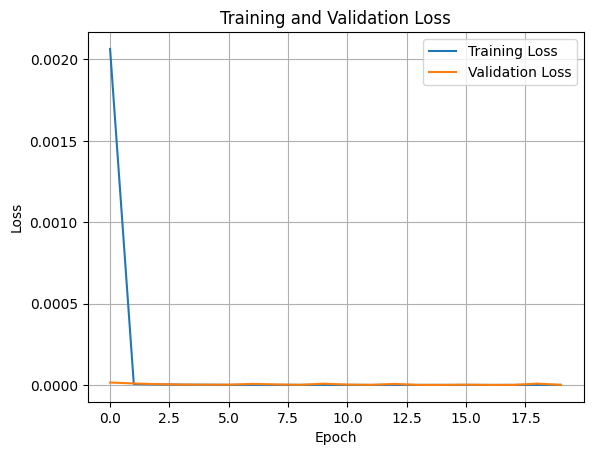

In [ ]:
plot_loss(history)

In [ ]:
# Generate recommendations for a given recipe
input_recipe = np.array([[170.9, 2.5, 1.3, 8.0, 29.8, 37.1, 3.6, 30.2, 3.2]])  # Replace with your input recipe

# Scale the input recipe using the same scaler
input_recipe_scaled = scaler.transform(input_recipe)

# Calculate similarity scores
similarity_scores = cosine_similarity(input_recipe_scaled, recipe_data_scaled)

# Get recommended recipe indices
top_indices = np.argsort(similarity_scores, axis=1)[0][::-1][:10]  # Get top 10 indices

# Filter out irrelevant columns
relevant_columns = ['Name', 'Images', 'CookTime', 'PrepTime', 'TotalTime', 'RecipeIngredientParts',
                    'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
                    'SodiumContent', 'CarbohydrateContent', 'FiberContent',
                    'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeInstructions']
recommendations = extracted_data.iloc[top_indices][relevant_columns]

recommendations.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,Name,Images,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions
0,Low-Fat Berry Blue Frozen Dessert,"c(""https://img.sndimg.com/food/image/upload/w_...",PT24H,PT45M,PT24H45M,"c(""blueberries"", ""granulated sugar"", ""vanilla ...",170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
520340,CHERRIES JUBILEE,"""https://img.sndimg.com/food/image/upload/w_55...",PT8M,PT5M,PT13M,"c(""cherries"", ""cherry brandy"", ""raw sugar"", ""c...",50.3,0.6,0.4,2.1,7.6,11.0,0.9,8.4,0.9,4.0,"c(""In a small saucepan on low heat, add cherry..."
520339,CHERRIES JUBILEE,"""https://img.sndimg.com/food/image/upload/w_55...",PT10M,PT5M,PT15M,"c(""cherries"", ""cherry brandy"", ""raw sugar"", ""c...",50.3,0.6,0.4,2.1,7.6,11.0,0.9,8.4,0.9,4.0,"c(""In a small saucepan on low heat, add cherry..."
485171,Glazed Pineapple With Cinnamon Creme Fraiche,"c(""https://img.sndimg.com/food/image/upload/w_...",PT10M,PT10M,PT20M,"c(""lime"", ""honey"", ""ground cinnamon"", ""ground ...",172.5,2.2,1.2,5.0,19.8,41.5,3.8,32.4,1.4,4.0,"c(""Mix the lime juice and half the lime zest w..."
157088,Orange Sorbet,"c(""https://img.sndimg.com/food/image/upload/w_...",PT4H,PT3M,PT4H3M,"c(""sweetened condensed milk"", ""orange"", ""lemon...",188.5,3.0,1.7,10.4,39.5,38.8,3.3,34.2,4.1,1.0,"c(""cut the top of the orange, use a spoon to t..."


### **System Recommendation based on Calories**

In [13]:
# Preprocess the data
calories = extracted_data['Calories'].values.reshape(-1, 1)
mean_calories = np.mean(calories)
std_calories = np.std(calories)
normalized_calories = (calories - mean_calories) / std_calories

In [41]:
# Create the TensorFlow model
input_dim = normalized_calories.shape[1]

model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_dim=input_dim),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_2 = model_2.fit(normalized_calories, normalized_calories, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1804/1804 [==============================] - 5s 2ms/step - loss: 0.0080 - val_loss: 4.6534e-06
Epoch 2/20
1804/1804 [==============================] - 4s 2ms/step - loss: 1.3290e-06 - val_loss: 1.4020e-07
Epoch 3/20
1804/1804 [==============================] - 5s 3ms/step - loss: 1.9689e-07 - val_loss: 5.8243e-08
Epoch 4/20
1804/1804 [==============================] - 4s 2ms/step - loss: 7.7957e-07 - val_loss: 1.0598e-07
Epoch 5/20
1804/1804 [==============================] - 10s 6ms/step - loss: 4.6926e-07 - val_loss: 6.7178e-08
Epoch 6/20
1804/1804 [==============================] - 4s 2ms/step - loss: 1.5013e-06 - val_loss: 2.4047e-05
Epoch 7/20
1804/1804 [==============================] - 4s 2ms/step - loss: 4.1554e-06 - val_loss: 4.7409e-09
Epoch 8/20
1804/1804 [==============================] - 9s 5ms/step - loss: 1.6238e-06 - val_loss: 9.9601e-09
Epoch 9/20
1804/1804 [==============================] - 5s 3ms/step - loss: 2.8214e-06 - val_loss: 3.7977e-09
Epoch 10/20
1

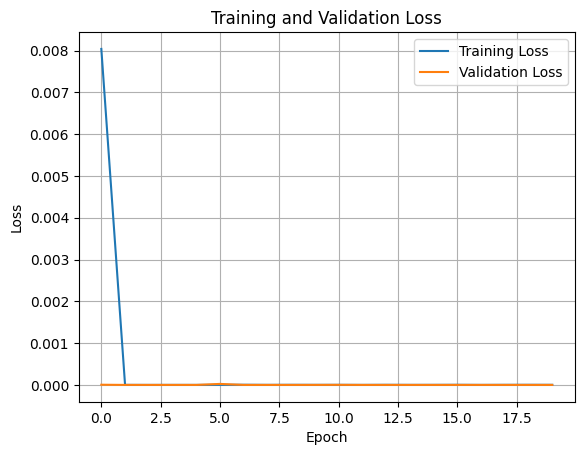

In [43]:
plot_loss(history_2)

In [44]:
from sklearn.metrics.pairwise import euclidean_distances

# Define the recommendation function
def get_recommendations(input_calories, top_k=5):
    # Calculate the Euclidean distances between input calories and all recipes
    distances = euclidean_distances(extracted_data[['Calories']], [[input_calories]])

    # Add distances as a new column in the dataset
    extracted_data['Distance'] = distances

    # Sort recipes based on the distances in ascending order
    sorted_recipes = extracted_data.sort_values('Distance')

    # Select top k recipes
    top_recipes = sorted_recipes.head(top_k)

    return top_recipes

# Test the recommendation system
input_calories = 1000  # Example input calories
recommended_recipes = get_recommendations(input_calories, top_k=5)

recommended_recipes.head()

,Name,Images,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,Distance
9705,Curried Mince Macaroni,"""https://img.sndimg.com/food/image/upload/w_55...",PT25M,PT10M,PT35M,"c(""pasta shells"", ""ground lamb"", ""onion"", ""tom...",1000.5,27.9,11.2,71.8,133.8,146.1,9.5,13.9,41.4,3.0,"c(""Take a deep pan and heat the 1& 1/2 tbsps o...",0.5
2193,Smoked Chicken &Artichoke Pasta,"""https://img.sndimg.com/food/image/upload/w_55...",PT25M,PT10M,PT35M,"c(""dry pasta"", ""leek"", ""garlic"", ""artichokes"",...",1000.7,37.9,6.4,80.6,1620.5,117.5,12.7,5.9,51.6,4.0,"c(""Cook the pasta following the directions, dr...",0.7
37852,The Challah Lady's Heavenly Challah,"c(""https://img.sndimg.com/food/image/upload/w_...",PT45M,PT2H30M,PT3H15M,"c(""bread flour"", ""water"", ""fresh yeast"", ""dry ...",1001.3,14.2,2.1,42.3,2115.5,189.3,6.6,15.7,25.2,10.0,"c(""Dissolve yeast, water, and 1 tablespoon of ...",1.3
7291,Garlic Chile Potato Kebabs,"""https://img.sndimg.com/food/image/upload/w_55...",PT20M,PT15M,PT35M,"c(""new potatoes"", ""garlic cloves"", ""olive oil"")",998.5,8.5,1.3,0.0,82.1,213.8,27.8,25.3,25.6,4.0,"c(""Boil, steam or microwave potatoes and onion...",1.5
16487,Tuscan Pork Chops,"c(""https://img.sndimg.com/food/image/upload/w_...",PT30M,PT10M,PT40M,"c(""garlic cloves"", ""carrots"", ""potatoes"", ""oni...",998.3,59.0,11.7,137.3,174.7,68.8,9.8,7.8,49.2,4.0,"c(""Layer the potatoes,garlic, onions, & carrot...",1.7


## **Convert Model for Deployment**

In [45]:
# Save the model in the SavedModel format
model_2.save("model_saved")

# Convert the SavedModel to TFLite model
converter = tf.lite.TFLiteConverter.from_saved_model("model_saved")
tflite_model = converter.convert()

# Save the TFLite model to a file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)